# Neurons (using meshes)

This tutorial demonstrates how to generate smaller numbers of neuron objects, but with the added option of linking data or callbacks to the objects. Hovering over and clicking on the objects can then provide feedback to the Python API.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/VirtualBrainLab/urchin-examples/blob/main/basics/neurons_meshes.ipynb)

## Install Urchin

Urchin is a Python package stored on PyPI, the following code needs to be run the first time you use Urchin in a Python environment. 

Urchin's full documentation can be found [on our website](https://virtualbrainlab.org/urchin/installation_and_use.html).

In [ ]:
#Installing urchin
!pip install oursin -U

## Load data

In [8]:
import numpy as np
import requests
import io

In [9]:
data_url = 'https://drive.google.com/file/d/1C9mCgecGxj1YwUUbTZ1zoqgeBUDskwex/view?usp=drive_link'

def download_google_drive_data(gdrive_url):
    file_id = gdrive_url.split("/")[-2]

    # Construct the direct download link
    download_url = f"https://drive.google.com/uc?export=download&id={file_id}"
    response = requests.get(download_url)

    if response.status_code == 200:
        data = np.load(io.BytesIO(response.content))
    else:
        response.raise_for_status()

    return data

coords = download_google_drive_data(data_url)

In [10]:
print(coords)

[[8520.  750. 3820.]
 [8520.  750. 3820.]
 [8520.  720. 3850.]
 ...
 [8350. 4400. 5750.]
 [8350. 4400. 5750.]
 [8350. 4420. 5720.]]


## Setup Urchin and open the renderer webpage 

By default Urchin opens the 3D renderer in a webpage. Make sure pop-ups are enabled, or the page won't open properly. You can also open the renderer site yourself by replacing [ID here] with the ID that is output by the call to `.setup()` at https://data.virtualbrainlab.org/Urchin/?ID=[ID here]

Note that Urchin communicates to the renderer webpage through an internet connection, we don't currently support offline use (we hope to add support in the future).

In [1]:
#Importing necessary libraries:
import oursin as urchin
urchin.setup()

(URN) connected to server
Login sent with ID: 5adc0ad1, copy this ID into the renderer to connect.


In [4]:
urchin.ccf25.load()

(Warning) Atlas was already loaded, the renderer can have issues if you try to load an atlas twice.


In [6]:
defaults = ['FRP','MO','SS','GU','VISC','AUD','VIS','ACA','PL',
            'ILA','ORB','AI','RSP','PTLp','TEa','PERI','OLF',
            'ECT','HPF','CTXsp','CNU','BS','CB']
area_list = urchin.ccf25.get_areas(defaults)
urchin.ccf25.set_visibilities(area_list, True, urchin.utils.Side.FULL)
urchin.ccf25.set_materials(area_list, 'transparent-unlit', 'full')
urchin.ccf25.set_alphas(area_list, 0.15, 'full')

## Creating meshes

To create mesh objects we'll call `urchin.primitives.create(n)`, passing the number of objects as a parameter.

In [11]:
pmeshes = urchin.meshes.create(len(coords)) #creates 2 primitives, stored in list pmeshes

In [12]:
# reorder to AP/ML/DV for Urchin and make a list of lists
coords_list = [[x[0], x[2], x[1]] for x in coords]
colors_list = ['#000000']*len(coords)
sizes_list = [[0.02,0.02,0.02]]*len(coords)

urchin.meshes.set_positions(pmeshes,coords_list) #sets the positions of the primitives
urchin.meshes.set_colors(pmeshes, colors_list)
urchin.meshes.set_scales(pmeshes, sizes_list)

In [13]:
urchin.camera.main.set_rotation([22.5, 22.5, 225])
urchin.camera.main.set_mode('perspective')
urchin.camera.main.set_zoom(45)
urchin.camera.main.set_background_color('#ffffff')

(Camera receive) Camera CameraMain received an image
(Camera receive) CameraMain complete


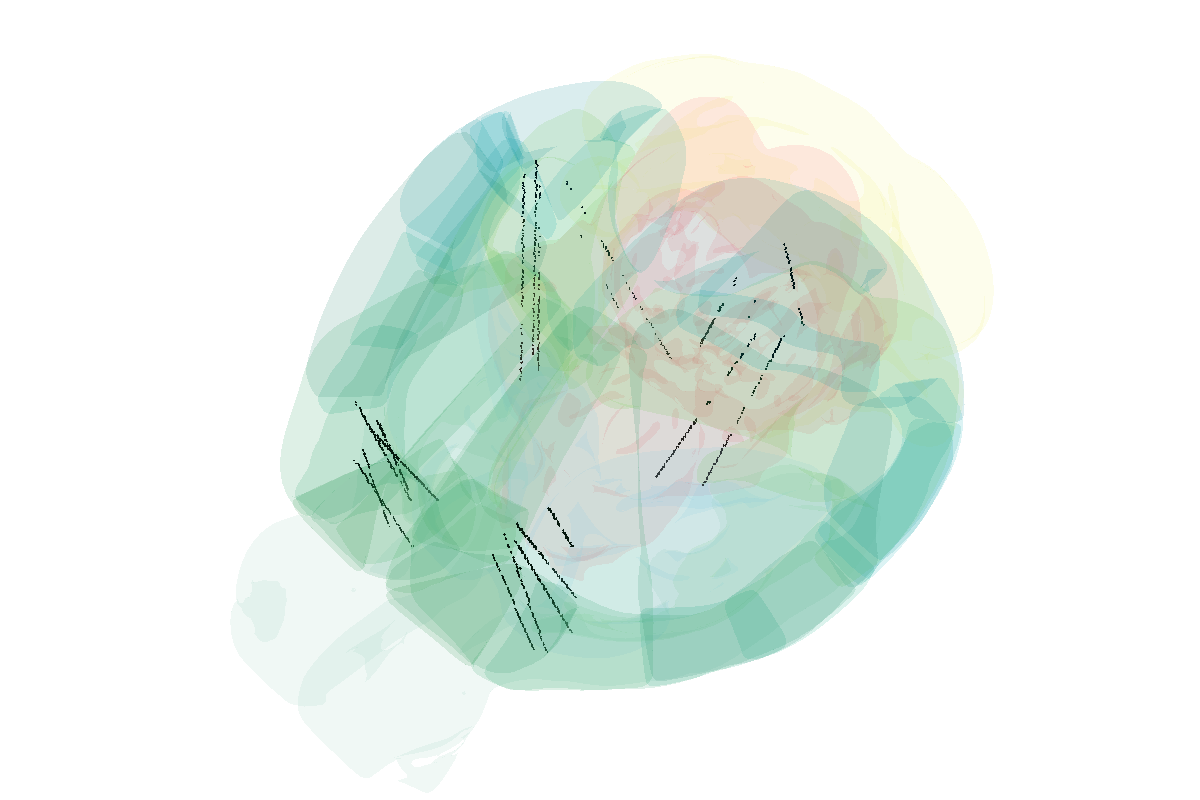

In [14]:
await urchin.camera.main.screenshot(size=[1200,800])

## Getting callback information back

You can define a custom callback function in Python by attaching it to `urchin.meshes.callback`. The input parameter will receive the index positions of the clicked neurons as a string.

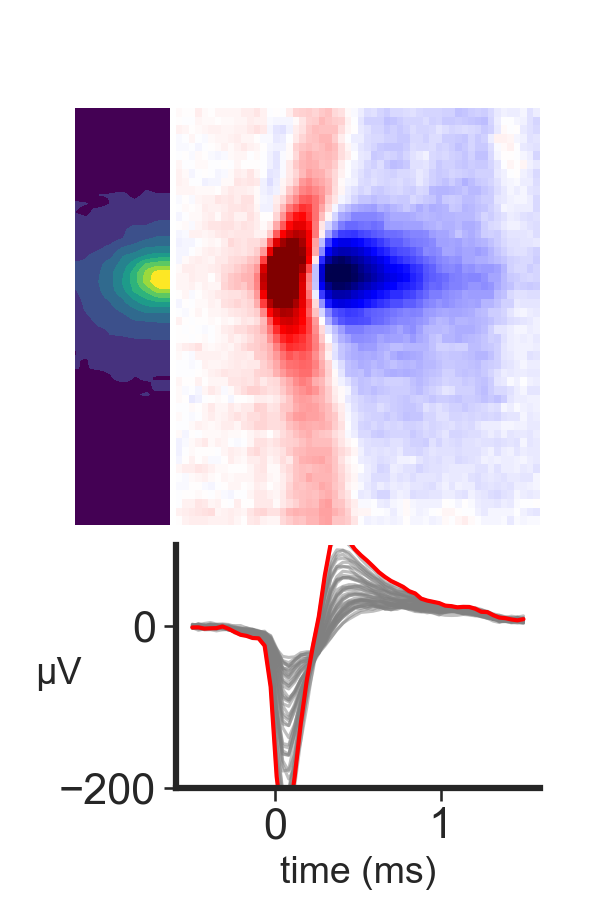

In [16]:
import requests
from IPython.display import display, Image, clear_output

def display_png_image(image_idx):
    # Construct the URL with the input parameter
    url = f'https://data.virtualbrainlab.org/Ultra/waveform{image_idx}.png'
    
    # Fetch the image using requests
    response = requests.get(url)
    
    if response.status_code == 200:
        # Display the image
        clear_output(wait=True)
        display(Image(data=response.content))
    else:
        print(f"Failed to fetch the image. Status code: {response.status_code}")

urchin.meshes.callback = display_png_image